#### **RQ2**
- RQ2a: Do concept-based interventions affect performance in different cheating groups?
- RQ2b: Do the effects on performance vary by concepts in different cheating groups?


We use a bayesian linear regression model to assess the effects of different interventions on the likelihood of performance in different cheating groups, using a hyper prior for the model.

In [1]:
# =============================================================================
# 1. SETUP AND DATA PREPARATION
# =============================================================================

import sys, os, warnings
sys.path.append('../')
warnings.filterwarnings('ignore')
os.chdir('game-behavior-analytics/data_analysis_notebook/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

# Load and prepare data
df = pd.read_csv("../data/final_dataset.csv")

def categorize_cheating(rate):
    return 0 if rate == 0 else 2 if rate == 1 else 1

# Create analysis variables for performance
df['cheating_behavior'] = df['cheating_rate_main_round'].apply(categorize_cheating)
df['performance'] = df['performance_score_including_cheated_words']
df['experience'] = (df['task_satisfaction'] + df['task_engagement']) / 2
df = df.dropna(subset=['cheating_behavior', 'performance', 'experience', 'concept'])

# Prepare categorical variables
concept_ids = df['concept'].astype('category')
if concept_ids.cat.categories[0] != 'control':
    concept_ids = concept_ids.cat.reorder_categories(['control'] + [c for c in concept_ids.cat.categories if c != 'control'])

concept_codes = concept_ids.cat.codes.values
concepts = [c for c in concept_ids.cat.categories if c != 'control']

# Create nested message structure: concept -> messages
message_df = df[['concept', 'motivational_message_id']].drop_duplicates()
concept_message_map = {}
for concept in concept_ids.cat.categories:
    messages = message_df[message_df['concept'] == concept]['motivational_message_id'].unique()
    concept_message_map[concept] = {msg: i for i, msg in enumerate(messages)}

# Create nested message indices
df['concept_idx'] = concept_codes
df['message_within_concept'] = df.apply(
    lambda row: concept_message_map[row['concept']][row['motivational_message_id']], axis=1
)


In [2]:
# =============================================================================
# 2. DESCRIPTIVE ANALYSIS BY CHEATING BEHAVIOR AND CONCEPT
# =============================================================================

def calc_stats_ci(data, col):
    """Calculate mean, standard error, and 95% CI for continuous variable."""
    n = len(data)
    mean = data[col].mean()
    std = data[col].std()
    se = std / np.sqrt(n) if n > 0 else 0
    ci_lower = mean - 1.96 * se
    ci_upper = mean + 1.96 * se
    return {
        'mean': mean,
        'std': std,
        'se': se,
        'ci': f"[{ci_lower:.2f}, {ci_upper:.2f}]",
        'n': n
    }

# Theory groupings for concept ordering
theory_order = [
    'autonomy', 'competence', 'relatedness',
    'self_concept', 'cognitive_inconsistency', 'dissonance_arousal', 'dissonance_reduction',
    'performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal',
    'descriptive_norms', 'injunctive_norms', 'social_sanctions', 'reference_group_identification'
]

control = df[df['concept'] == 'control']
intervention = df[df['concept'] != 'control']

# Performance by cheating behavior overall
print("=" * 120)
print("PERFORMANCE BY CHEATING BEHAVIOR")
print("=" * 120)
print(f"{'Group':<25} {'Non-cheater [95% CI]':<25} {'Partial [95% CI]':<25} {'Full [95% CI]':<25} {'Overall [95% CI]':<25}")
print("-" * 120)

# Control group by cheating behavior
control_non = control[control['cheating_behavior'] == 0]
control_partial = control[control['cheating_behavior'] == 1]
control_full = control[control['cheating_behavior'] == 2]

control_non_stats = calc_stats_ci(control_non, 'performance')
control_partial_stats = calc_stats_ci(control_partial, 'performance')
control_full_stats = calc_stats_ci(control_full, 'performance')
control_overall_stats = calc_stats_ci(control, 'performance')

print(f"{'Control':<25} "
      f"{control_non_stats['mean']:>6.2f} {control_non_stats['ci']:<12} "
      f"{control_partial_stats['mean']:>6.2f} {control_partial_stats['ci']:<12} "
      f"{control_full_stats['mean']:>6.2f} {control_full_stats['ci']:<12} "
      f"{control_overall_stats['mean']:>6.2f} {control_overall_stats['ci']:<12}")

# Intervention group by cheating behavior
interv_non = intervention[intervention['cheating_behavior'] == 0]
interv_partial = intervention[intervention['cheating_behavior'] == 1]
interv_full = intervention[intervention['cheating_behavior'] == 2]

interv_non_stats = calc_stats_ci(interv_non, 'performance')
interv_partial_stats = calc_stats_ci(interv_partial, 'performance')
interv_full_stats = calc_stats_ci(interv_full, 'performance')
interv_overall_stats = calc_stats_ci(intervention, 'performance')

print(f"{'Intervention':<25} "
      f"{interv_non_stats['mean']:>6.2f} {interv_non_stats['ci']:<12} "
      f"{interv_partial_stats['mean']:>6.2f} {interv_partial_stats['ci']:<12} "
      f"{interv_full_stats['mean']:>6.2f} {interv_full_stats['ci']:<12} "
      f"{interv_overall_stats['mean']:>6.2f} {interv_overall_stats['ci']:<12}")

# Differences
print("-" * 120)
print("MEAN DIFFERENCES (Intervention - Control)")
print("-" * 120)

non_diff = interv_non_stats['mean'] - control_non_stats['mean']
partial_diff = interv_partial_stats['mean'] - control_partial_stats['mean']
full_diff = interv_full_stats['mean'] - control_full_stats['mean']
overall_diff = interv_overall_stats['mean'] - control_overall_stats['mean']

non_se_diff = np.sqrt(interv_non_stats['se']**2 + control_non_stats['se']**2)
partial_se_diff = np.sqrt(interv_partial_stats['se']**2 + control_partial_stats['se']**2)
full_se_diff = np.sqrt(interv_full_stats['se']**2 + control_full_stats['se']**2)
overall_se_diff = np.sqrt(interv_overall_stats['se']**2 + control_overall_stats['se']**2)

non_ci = f"[{non_diff - 1.96*non_se_diff:.2f}, {non_diff + 1.96*non_se_diff:.2f}]"
partial_ci = f"[{partial_diff - 1.96*partial_se_diff:.2f}, {partial_diff + 1.96*partial_se_diff:.2f}]"
full_ci = f"[{full_diff - 1.96*full_se_diff:.2f}, {full_diff + 1.96*full_se_diff:.2f}]"
overall_ci = f"[{overall_diff - 1.96*overall_se_diff:.2f}, {overall_diff + 1.96*overall_se_diff:.2f}]"

print(f"{'Difference':<25} "
      f"{non_diff:+6.2f} {non_ci:<12} "
      f"{partial_diff:+6.2f} {partial_ci:<12} "
      f"{full_diff:+6.2f} {full_ci:<12} "
      f"{overall_diff:+6.2f} {overall_ci:<12}")

# Performance by concept and cheating behavior
print("\n" + "=" * 160)
print("PERFORMANCE BY CONCEPT AND CHEATING BEHAVIOR - MEAN DIFFERENCES vs CONTROL")
print("=" * 160)
print(f"{'Concept':<35} {'Non-cheater [95% CI]':<30} {'Partial [95% CI]':<30} {'Full [95% CI]':<30} {'Overall [95% CI]':<30}")
print("-" * 160)

for concept in theory_order:
    if concept in df['concept'].unique():
        subset = df[df['concept'] == concept]
        
        # By cheating behavior
        subset_non = subset[subset['cheating_behavior'] == 0]
        subset_partial = subset[subset['cheating_behavior'] == 1]
        subset_full = subset[subset['cheating_behavior'] == 2]
        
        concept_clean = concept.replace('_', ' ').title()
        row = f"{concept_clean:<35}"
        
        # Calculate differences for each cheating group
        if len(subset_non) > 0:
            subset_non_stats = calc_stats_ci(subset_non, 'performance')
            non_diff = subset_non_stats['mean'] - control_non_stats['mean']
            non_se_diff = np.sqrt(subset_non_stats['se']**2 + control_non_stats['se']**2)
            non_ci = f"[{non_diff - 1.96*non_se_diff:.2f}, {non_diff + 1.96*non_se_diff:.2f}]"
            row += f"{non_diff:+6.2f} {non_ci:<18}"
        else:
            row += f"{'N/A':<30}"
            
        if len(subset_partial) > 0:
            subset_partial_stats = calc_stats_ci(subset_partial, 'performance')
            partial_diff = subset_partial_stats['mean'] - control_partial_stats['mean']
            partial_se_diff = np.sqrt(subset_partial_stats['se']**2 + control_partial_stats['se']**2)
            partial_ci = f"[{partial_diff - 1.96*partial_se_diff:.2f}, {partial_diff + 1.96*partial_se_diff:.2f}]"
            row += f"{partial_diff:+6.2f} {partial_ci:<18}"
        else:
            row += f"{'N/A':<30}"
            
        if len(subset_full) > 0:
            subset_full_stats = calc_stats_ci(subset_full, 'performance')
            full_diff = subset_full_stats['mean'] - control_full_stats['mean']
            full_se_diff = np.sqrt(subset_full_stats['se']**2 + control_full_stats['se']**2)
            full_ci = f"[{full_diff - 1.96*full_se_diff:.2f}, {full_diff + 1.96*full_se_diff:.2f}]"
            row += f"{full_diff:+6.2f} {full_ci:<18}"
        else:
            row += f"{'N/A':<30}"
            
        # Overall
        subset_overall_stats = calc_stats_ci(subset, 'performance')
        overall_diff = subset_overall_stats['mean'] - control_overall_stats['mean']
        overall_se_diff = np.sqrt(subset_overall_stats['se']**2 + control_overall_stats['se']**2)
        overall_ci = f"[{overall_diff - 1.96*overall_se_diff:.2f}, {overall_diff + 1.96*overall_se_diff:.2f}]"
        row += f"{overall_diff:+6.2f} {overall_ci:<18}"
        
        print(row)

PERFORMANCE BY CHEATING BEHAVIOR
Group                     Non-cheater [95% CI]      Partial [95% CI]          Full [95% CI]             Overall [95% CI]         
------------------------------------------------------------------------------------------------------------------------
Control                    14.67 [12.18, 17.15]  20.60 [13.25, 27.95]  30.25 [24.71, 35.79]  20.60 [17.68, 23.52]
Intervention               17.19 [16.44, 17.94]  17.94 [16.68, 19.20]  27.73 [25.92, 29.54]  19.34 [18.67, 20.01]
------------------------------------------------------------------------------------------------------------------------
MEAN DIFFERENCES (Intervention - Control)
------------------------------------------------------------------------------------------------------------------------
Difference                 +2.53 [-0.07, 5.12]  -2.66 [-10.11, 4.80]  -2.52 [-8.35, 3.31]  -1.26 [-4.26, 1.74]

PERFORMANCE BY CONCEPT AND CHEATING BEHAVIOR - MEAN DIFFERENCES vs CONTROL
Concept          

In [5]:
# =============================================================================
# 3. BAYESIAN LINEAR REGRESSION MODEL WITH CHEATING BEHAVIOR
# =============================================================================

print("\n" + "="*70)
print("BAYESIAN LINEAR REGRESSION FOR PERFORMANCE WITH CHEATING BEHAVIOR")
print("="*70)

# Control group baseline
control_baseline_mean = control['performance'].mean()
control_baseline_sd = control['performance'].std()

# Calculate control group means by cheating behavior
control_means_perf = np.array([
    control[control['cheating_behavior'] == 0]['performance'].mean(),
    control[control['cheating_behavior'] == 1]['performance'].mean(),
    control[control['cheating_behavior'] == 2]['performance'].mean()
])

with pm.Model() as performance_model:
    
    # Control group means for each cheating behavior (0=non, 1=partial, 2=full)
    mu_perf_control = pm.Normal('Control Performance Means', mu=control_means_perf, sigma=3.0, shape=3)
    
    # Main concept effects
    mu_concept = pm.Normal('Mean Concept Effect', mu=0, sigma=1.0)
    sigma_concept = pm.HalfNormal('SD Concept Effect', sigma=1.0)
    concept_perf_main = pm.Normal('Concept Main Effects', mu=mu_concept, sigma=sigma_concept, shape=len(concepts))
    
    # Concept × cheating behavior interactions
    mu_concept_interactions = pm.Normal('Mean Concept Interactions', mu=0, sigma=1.0, shape=3)
    sigma_concept_interactions = pm.HalfNormal('SD Concept Interactions', sigma=1.0, shape=3)
    concept_perf_interactions = pm.Normal('Concept × Cheating Interactions', 
                                        mu=mu_concept_interactions, sigma=sigma_concept_interactions, 
                                        shape=(len(concepts), 3))
    
    # Linear predictor
    mu_perf = mu_perf_control[df['cheating_behavior'].values]
    
    # Add concept effects for intervention groups
    concept_effect = pm.math.switch(
        df['concept_idx'].values > 0,
        concept_perf_main[df['concept_idx'].values - 1] + 
        concept_perf_interactions[df['concept_idx'].values - 1, df['cheating_behavior'].values],
        0
    )
    
    mu_perf = mu_perf + concept_effect
    
    # Residual standard deviation
    sigma_perf = pm.HalfNormal('Residual SD', sigma=5.0)
    
    # Likelihood with truncation for positive performance
    pm.TruncatedNormal('Observed Performance', mu=mu_perf, sigma=sigma_perf,
                      lower=0, upper=df['performance'].max() + 20, 
                      observed=df['performance'].values)

# Model fitting
print("Fitting Bayesian model...")
with performance_model:
    trace_performance = pm.sample(1500, tune=1000, chains=4, cores=4, target_accept=0.9, random_seed=42)
    ppc_performance = pm.sample_posterior_predictive(trace_performance, random_seed=42)

print("Model fitting completed.")


BAYESIAN LINEAR REGRESSION FOR PERFORMANCE WITH CHEATING BEHAVIOR
Fitting Bayesian model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Control Performance Means, Mean Concept Effect, SD Concept Effect, Concept Main Effects, Mean Concept Interactions, SD Concept Interactions, Concept × Cheating Interactions, Residual SD]


Output()

Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 295 seconds.
There were 535 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [Observed Performance]


Output()

Model fitting completed.


In [11]:
# =============================
# SUMMARY OF RESULTS (Posteriors) 
# =============================

# Extract posterior samples
control_means_samples = trace_performance.posterior['Control Performance Means'].values.reshape(-1, 3)
concept_main_samples = trace_performance.posterior['Concept Main Effects'].values.reshape(-1, len(concepts))
concept_interactions_samples = trace_performance.posterior['Concept × Cheating Interactions'].values.reshape(-1, len(concepts), 3)

# Theory groupings for concept ordering
theory_order = [
    'autonomy', 'competence', 'relatedness',  # Self-Determination
    'self_concept', 'cognitive_inconsistency', 'dissonance_arousal', 'dissonance_reduction',  # Cognitive Dissonance
    'performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal',  # Self-Efficacy
    'descriptive_norms', 'injunctive_norms', 'social_sanctions', 'reference_group_identification'  # Social Norms
]

theory_map = {
    'autonomy': 'Self-Determination Theory', 'competence': 'Self-Determination Theory', 'relatedness': 'Self-Determination Theory',
    'self_concept': 'Cognitive Dissonance Theory', 'cognitive_inconsistency': 'Cognitive Dissonance Theory', 
    'dissonance_arousal': 'Cognitive Dissonance Theory', 'dissonance_reduction': 'Cognitive Dissonance Theory',
    'performance_accomplishments': 'Self-Efficacy Theory', 'vicarious_experience': 'Self-Efficacy Theory', 
    'verbal_persuasion': 'Self-Efficacy Theory', 'emotional_arousal': 'Self-Efficacy Theory',
    'descriptive_norms': 'Social Norms Theory', 'injunctive_norms': 'Social Norms Theory', 
    'social_sanctions': 'Social Norms Theory', 'reference_group_identification': 'Social Norms Theory'
}

# Calculate performance differences for each concept with HDI
results_performance = []
concept_differences_perf = {}  # Store for reuse in forest plots

for concept in theory_order:
    if concept in concepts:
        i = concepts.index(concept)
        
        # For each cheating behavior category
        differences = {}
        for cheat_cat in [0, 1, 2]:  # Non-cheater, Partial, Full
            # Control baseline for this cheating category
            control_baseline = control_means_samples[:, cheat_cat]
            
            # Intervention effect for this concept and cheating category
            intervention_effect = (control_baseline + 
                                 concept_main_samples[:, i] + 
                                 concept_interactions_samples[:, i, cheat_cat])
            
            # Calculate difference
            diff = intervention_effect - control_baseline
            differences[cheat_cat] = diff
        
        # Store for reuse
        concept_differences_perf[concept] = differences
        
        results_performance.append({
            'Concept': concept.replace('_', ' ').title(),
            'Theory': theory_map[concept],
            'Non_mean': differences[0].mean(),
            'Non_hdi': az.hdi(differences[0], hdi_prob=0.95),
            'Partial_mean': differences[1].mean(),
            'Partial_hdi': az.hdi(differences[1], hdi_prob=0.95),
            'Full_mean': differences[2].mean(),
            'Full_hdi': az.hdi(differences[2], hdi_prob=0.95)
        })

df_results_perf = pd.DataFrame(results_performance)

# Calculate overall intervention effects across all concepts
overall_effects_perf = {}
for cheat_cat in [0, 1, 2]:
    # Average across all concepts for this cheating category
    all_concept_effects = []
    for i in range(len(concepts)):
        control_baseline = control_means_samples[:, cheat_cat]
        intervention_effect = (control_baseline + 
                             concept_main_samples[:, i] + 
                             concept_interactions_samples[:, i, cheat_cat])
        diff = intervention_effect - control_baseline
        all_concept_effects.append(diff)
    
    # Average effect across concepts
    overall_diff = np.mean(all_concept_effects, axis=0)
    overall_effects_perf[cheat_cat] = {
        'mean': overall_diff.mean(),
        'hdi': az.hdi(overall_diff, hdi_prob=0.95)
    }

# Control baselines for reference
control_baselines = {
    'Non': control_means_samples[:, 0].mean(),
    'Partial': control_means_samples[:, 1].mean(),
    'Full': control_means_samples[:, 2].mean()
}

# Print results with HDI
print("Performance Changes (points) with 95% HDI:")
print(f"{'Concept':<35} {'Theory':<30} {'Non-cheater':<25} {'Partial':<25} {'Full':<25}")
print("-" * 130)
for _, row in df_results_perf.iterrows():
    non_str = f"{row['Non_mean']:+.2f} [{row['Non_hdi'][0]:+.2f}, {row['Non_hdi'][1]:+.2f}]"
    partial_str = f"{row['Partial_mean']:+.2f} [{row['Partial_hdi'][0]:+.2f}, {row['Partial_hdi'][1]:+.2f}]"
    full_str = f"{row['Full_mean']:+.2f} [{row['Full_hdi'][0]:+.2f}, {row['Full_hdi'][1]:+.2f}]"
    print(f"{row['Concept']:<35} {row['Theory']:<30} {non_str:<25} {partial_str:<25} {full_str:<25}")

print("\n" + "="*70)
print("OVERALL INTERVENTION EFFECTS")
print("="*70)
print(f"{'Cheating Behavior':<20} {'Mean Change [95% HDI]':<30} {'Control Baseline':<20}")
print("-" * 70)

categories = ['Non-cheater', 'Partial cheater', 'Full cheater']
cat_keys = ['Non', 'Partial', 'Full']

for i, (cat_name, cat_key) in enumerate(zip(categories, cat_keys)):
    mean_change = overall_effects_perf[i]['mean']
    hdi = overall_effects_perf[i]['hdi']
    baseline = control_baselines[cat_key]
    
    change_str = f"{mean_change:+.2f} [{hdi[0]:+.2f}, {hdi[1]:+.2f}]"
    print(f"{cat_name:<20} {change_str:<30} {baseline:.2f}")

Performance Changes (points) with 95% HDI:
Concept                             Theory                         Non-cheater               Partial                   Full                     
----------------------------------------------------------------------------------------------------------------------------------
Autonomy                            Self-Determination Theory      +0.02 [-2.82, +2.97]      -1.07 [-4.22, +1.81]      -1.00 [-3.82, +1.89]     
Competence                          Self-Determination Theory      +0.05 [-2.69, +3.05]      -0.89 [-3.87, +2.32]      -0.75 [-3.66, +1.88]     
Relatedness                         Self-Determination Theory      +0.15 [-2.62, +2.98]      -0.84 [-3.84, +2.11]      -0.64 [-3.57, +2.20]     
Self Concept                        Cognitive Dissonance Theory    -0.03 [-2.78, +2.94]      -0.95 [-3.83, +2.25]      -0.58 [-3.46, +2.22]     
Cognitive Inconsistency             Cognitive Dissonance Theory    -0.41 [-3.09, +2.68]      -1.24 [-

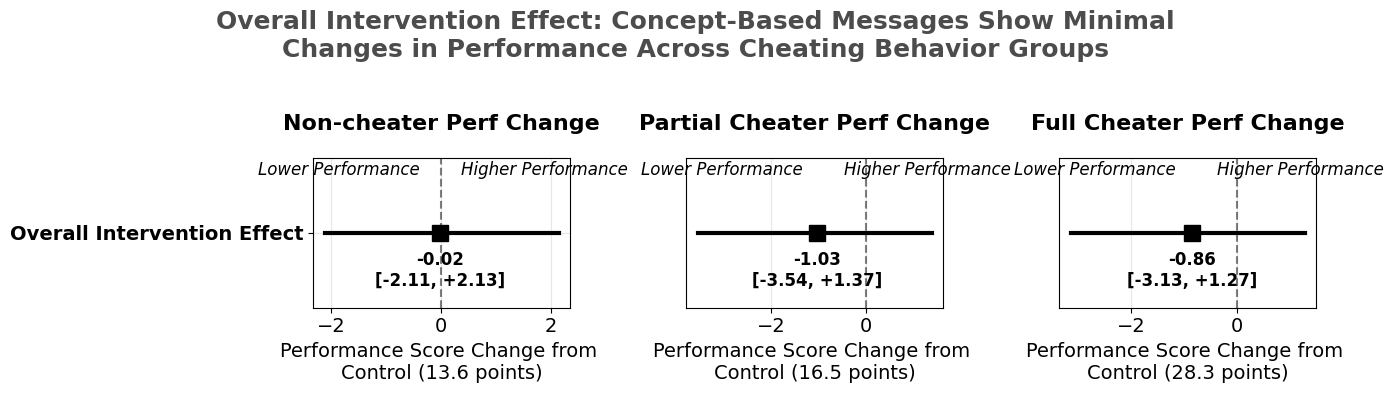

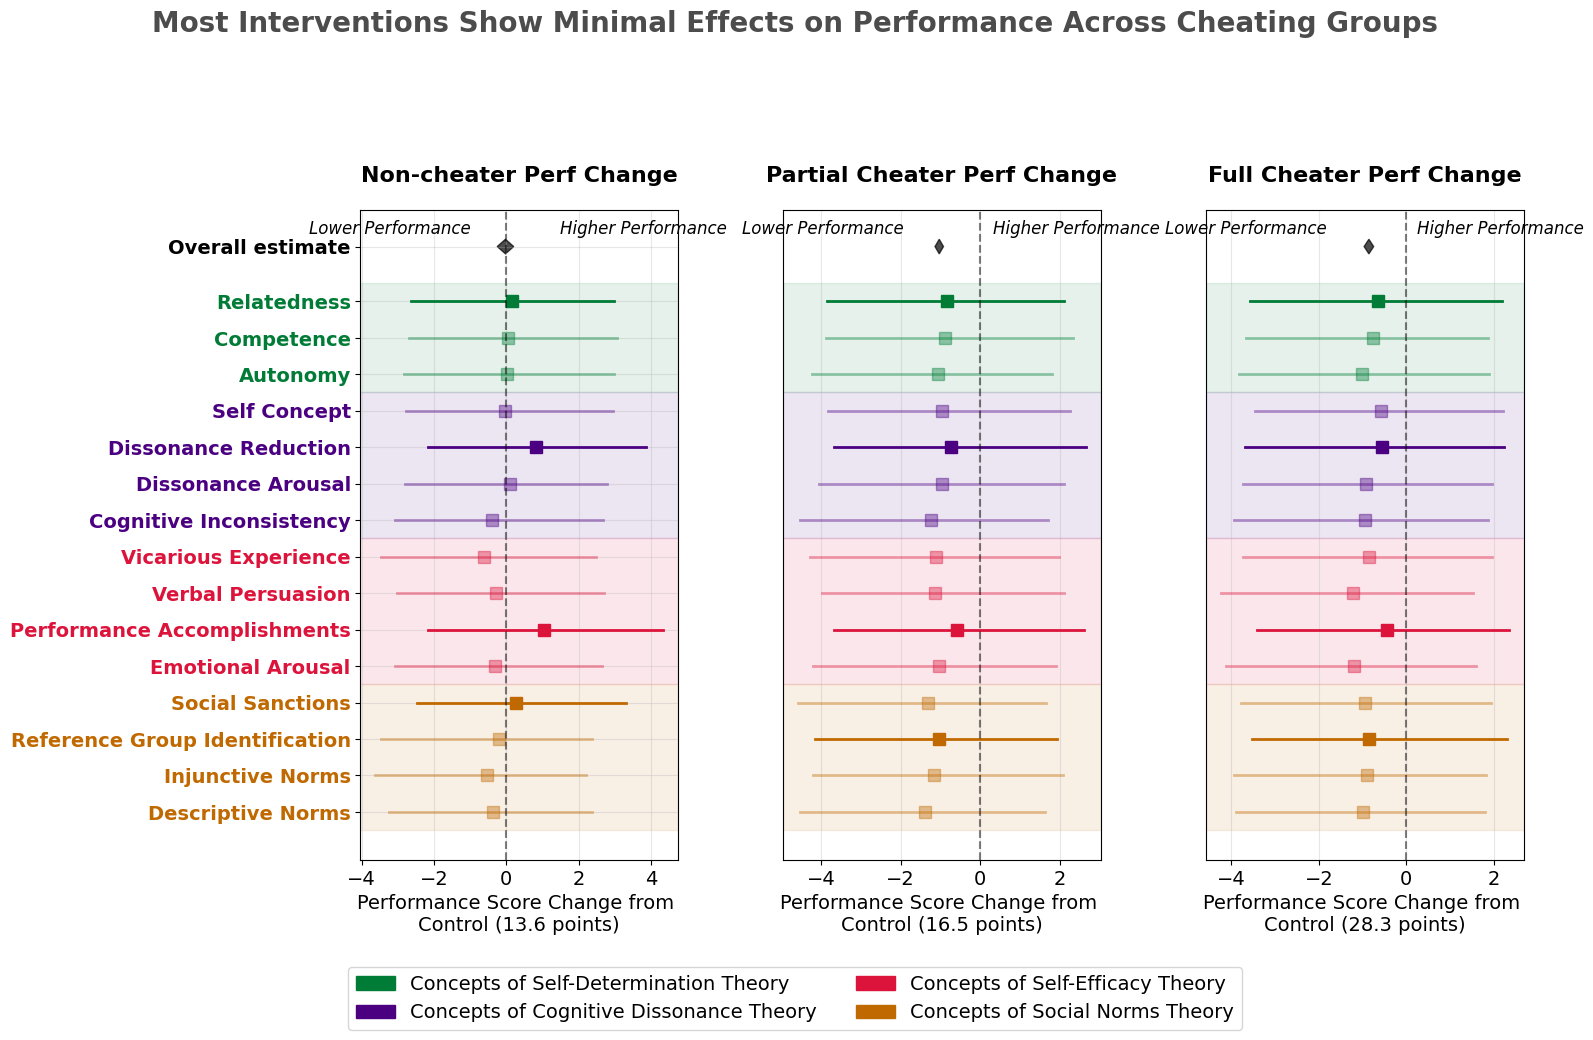

In [14]:
# ===============================================================
# FOREST PLOTS FOR PERFORMANCE CHANGES (posterior with 95% HDI)
# ================================================================

import matplotlib.patches as patches

categories = ['Non', 'Partial', 'Full']
titles = ['Non-cheater Perf Change', 'Partial Cheater Perf Change', 'Full Cheater Perf Change']

# PLOT 1: Overall intervention effect
fig1, axes1 = plt.subplots(1, 3, figsize=(14, 4))

for idx, (cat, title) in enumerate(zip(categories, titles)):
    ax = axes1[idx]
    
    mean = overall_effects_perf[idx]['mean']
    hdi = overall_effects_perf[idx]['hdi']
    
    ax.plot([hdi[0], hdi[1]], [0, 0], color='black', linewidth=3)
    ax.plot(mean, 0, 's', color='black', markersize=12)
    
    ax.text(mean, -0.15, f'{mean:+.2f}\n[{hdi[0]:+.2f}, {hdi[1]:+.2f}]', 
            ha='center', va='center', fontweight='bold', fontsize=12)
    
    ax.axvline(0, color='black', linestyle='--', alpha=0.5)
    
    if idx == 0:
        ax.set_yticks([0])
        ax.set_yticklabels(['Overall Intervention Effect'], fontsize=14, fontweight='bold')
    else:
        ax.set_yticks([])
    
    ax.tick_params(axis='x', labelsize=14)
    ax.set_xlabel(f'Performance Score Change from \nControl ({control_baselines[cat]:.1f} points)', fontsize=14)
    ax.set_title(title, fontweight='bold', fontsize=16, pad=20)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.3, 0.3)
    
    xlim = ax.get_xlim()
    ax.text(xlim[0] * 0.8, 0.25, 'Lower Performance', ha='center', va='center', fontsize=12, style='italic')
    ax.text(xlim[1] * 0.8, 0.25, 'Higher Performance', ha='center', va='center', fontsize=12, style='italic')

plt.suptitle('Overall Intervention Effect: Concept-Based Messages Show Minimal\nChanges in Performance Across Cheating Behavior Groups', 
             fontsize=18, fontweight='bold', color="black", alpha=0.7, y=0.97)
plt.tight_layout()
plt.subplots_adjust(top=0.6)
plt.show()

# PLOT 2: By-concept effects
fig2, axes2 = plt.subplots(1, 3, figsize=(16, 10))

theory_order_viz = ['Self-Determination Theory', 'Cognitive Dissonance Theory', 'Self-Efficacy Theory', 'Social Norms Theory'][::-1]
theory_colors = {'Self-Determination Theory': "#007C36", 'Cognitive Dissonance Theory': '#4B0082',
                 'Self-Efficacy Theory': '#DC143C', 'Social Norms Theory': "#C06900"}

df_results_perf['Theory'] = pd.Categorical(df_results_perf['Theory'], categories=theory_order_viz, ordered=True)
df_results_sorted = df_results_perf.sort_values(['Theory', 'Concept']).reset_index(drop=True)

for idx, (cat, title) in enumerate(zip(categories, titles)):
    ax = axes2[idx]
    means = df_results_sorted[f'{cat}_mean'].values
    hdis = np.array([row[f'{cat}_hdi'] for _, row in df_results_sorted.iterrows()])
    
    y_positions = np.arange(len(df_results_sorted))
    
    # Highlight best concept per theory (highest performance increase)
    highlight_indices = []
    for theory in theory_order_viz:
        indices = df_results_sorted.index[df_results_sorted['Theory'] == theory].tolist()
        if indices:
            theory_means = means[indices]
            target_idx = indices[np.argmax(theory_means)]
            highlight_indices.append(target_idx)
    
    # Background shading and forest plot
    for theory in theory_order_viz:
        indices = df_results_sorted.index[df_results_sorted['Theory'] == theory].tolist()
        if indices:
            ax.axhspan(indices[0]-0.5, indices[-1]+0.5, alpha=0.1, color=theory_colors[theory])
    
    for i in range(len(df_results_sorted)):
        color = theory_colors[df_results_sorted.iloc[i]['Theory']]
        alpha = 1.0 if i in highlight_indices else 0.4
        ax.plot([hdis[i][0], hdis[i][1]], [i, i], color=color, alpha=alpha, linewidth=2)
        ax.plot(means[i], i, 's', color=color, alpha=alpha, markersize=8)
    
    # Overall estimate diamond
    overall_mean = means.mean()
    overall_se = np.std(means) / np.sqrt(len(means))
    diamond_y = len(df_results_sorted) + 0.5
    diamond_x = [overall_mean - 1.96*overall_se, overall_mean, overall_mean + 1.96*overall_se, overall_mean, overall_mean - 1.96*overall_se]
    diamond_y_coords = [diamond_y, diamond_y + 0.2, diamond_y, diamond_y - 0.2, diamond_y]
    ax.fill(diamond_x, diamond_y_coords, color='black', alpha=0.7)
    
    ax.axvline(0, color='black', linestyle='--', alpha=0.5)

    if idx == 0:
        ax.set_yticks(list(y_positions) + [diamond_y])
        y_labels = df_results_sorted['Concept'].tolist() + ['Overall estimate']
        ax.set_yticklabels(y_labels, fontsize=14, fontweight='bold')

        for tick_label, concept in zip(ax.get_yticklabels()[:-1], df_results_sorted['Concept']):
            theory = df_results_sorted.loc[df_results_sorted['Concept'] == concept, 'Theory'].values[0]
            tick_label.set_color(theory_colors[theory])
        ax.get_yticklabels()[-1].set_color('black')
    else:
        ax.set_yticks([])

    ax.tick_params(axis='x', labelsize=14)
    ax.set_xlabel(f'Performance Score Change from \nControl ({control_baselines[cat]:.1f} points)', fontsize=14)
    ax.set_title(title, fontweight='bold', fontsize=16, pad=20)
    ax.grid(True, alpha=0.3)
    
    xlim = ax.get_xlim()
    ax.text(xlim[0] * 0.8, len(df_results_sorted) + 1, 'Lower Performance', ha='center', va='center', fontsize=12, style='italic')
    ax.text(xlim[1] * 0.8, len(df_results_sorted) + 1, 'Higher Performance', ha='center', va='center', fontsize=12, style='italic')

legend_elements = [patches.Patch(color=color, label=f"Concepts of {theory}") for theory, color in theory_colors.items()]
fig2.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.08), ncol=2, fontsize=14)

plt.suptitle('Most Interventions Show Minimal Effects on Performance Across Cheating Groups', 
             fontsize=20, fontweight='bold', color='black', alpha=0.7, y=0.95)

plt.tight_layout()
plt.subplots_adjust(top=0.75, bottom=0.1)
plt.show()